In [1]:
import numpy as np
from scipy.integrate import solve_ivp
from time import time
import matplotlib.pyplot as plt
import pandas as pd
import math
from scipy.optimize import minimize

# import cupy as cp

In [2]:
t_min = 0
t_end = 24 * 100

動かせる範囲
- Ser
    - 動かせる
    - いったん正の範囲
    - 感覚的には 0~1000
- X_max
    - 動かせる
    - 1.3*1e6 が最大値

- K_ser
    - 動かない
- P
    - 動かない

In [3]:
# # 定数の設定
# P = 1/24  # cycle_1
# X_max = 1.3 * 1e6  # Okumura
# Ser = 1 # cylce_1(Nakai)
# K_ser = 0  # cycle_1(Nakai)

# k_DNA = 1  # cycle_1
# k_s = 3e-2  # cycle_1(Nakai)
# k_dRNA = 3e-2  # cycle_1(Nakai)

# # 定数の設定
# k_vp = 1e-2 # cycle_1(Nakai)
# K_RNA = 0.2*1e4  # Okumura
# k_a = 7.8 * 1e-8  # k_aの値を適切に設定してください


# # 初期条件
# X0 = 0.2 * 1e6  # Xの初期値を適切に設定してください
# DNA0 = 2.0 * 1e11  # Okumura
# # DNA0 = 2.0 * 1e8
# RNA0 = 0.0  # Okumura
# SRIP0 = 0.0  # SRIPの初期値を適切に設定してください

In [4]:
P = math.log(2)/24
X_max = 1.3*10**6
Ser = 1
K_ser = 0
k_DNA = math.log(2)/24
k_s = 3e-2
k_dRNA = 3e-2
k_vp = 1e-2
K_RNA = 0.2*10**4
k_a = 7.8*10**(-8)


X0 = 0.2 * 1e6  # Xの初期値を適切に設定してください
# DNA0 = 5.5 * 1e4  # Okumura
DNA0 = 2.0 * 1e11

DNA0 = DNA0 / X0 * 0.8
RNA0 = 0.0  # Okumura
SRIP0 = 0.0  # SRIPの初期値を適切に設定してください

# SRIP Producing Cell

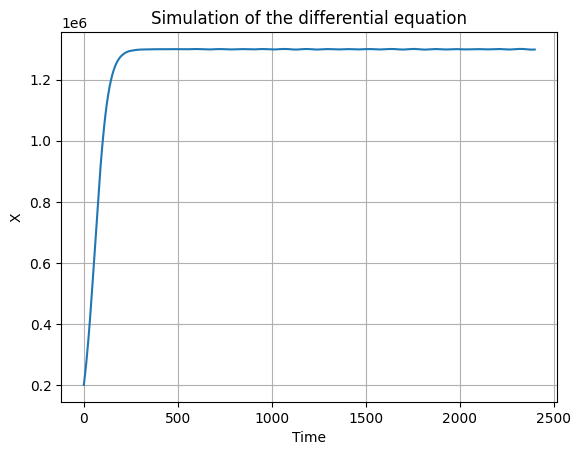

In [5]:
# 微分方程式の定義
def model(t, X):
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    return dXdt

# solve_ivpを使用して微分方程式を解く
sol_cell = solve_ivp(model, [t_min, t_end], [X0], t_eval=np.linspace(t_min, t_end, 1000))

# 結果のプロット
plt.plot(sol_cell.t, sol_cell.y[0])
plt.xlabel('Time')
plt.ylabel('X')
plt.title('Simulation of the differential equation')
plt.grid(True)
plt.show()

# DNA & RNA

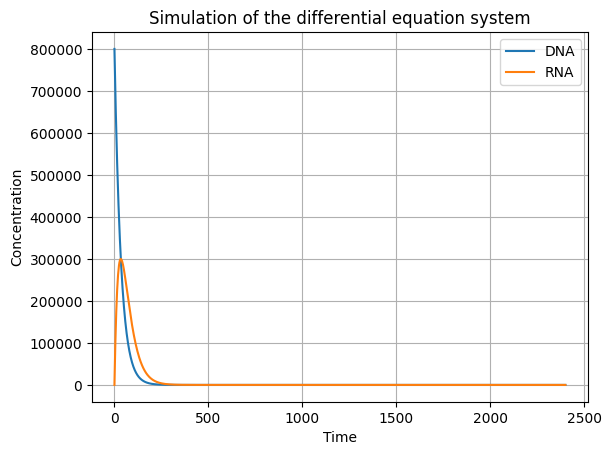

In [6]:
# 微分方程式系の定義
def model(t, y):
    DNA, RNA = y
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    
    return [dDNAdt, dRNAdt]

# solve_ivpを使用して微分方程式系を解く
sol_rna = solve_ivp(model, [t_min, t_end], [DNA0, RNA0], t_eval=np.linspace(t_min, t_end, 1000))

# 結果のプロット
plt.plot(sol_rna.t, sol_rna.y[0], label='DNA')
plt.plot(sol_rna.t, sol_rna.y[1], label='RNA')
plt.xlabel('Time')
plt.ylabel('Concentration')
plt.title('Simulation of the differential equation system')
plt.legend()
plt.grid(True)
plt.show()

# SRIP

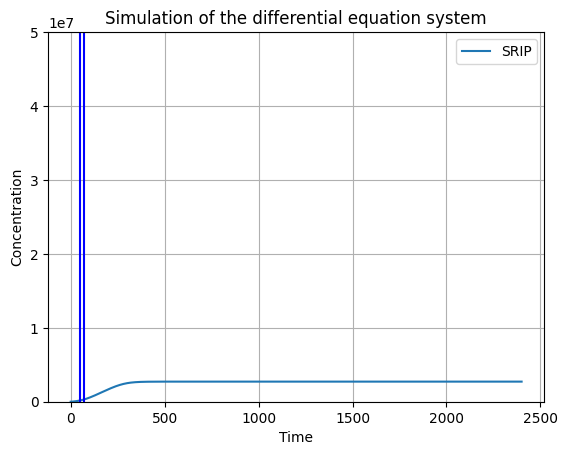

In [7]:
# RNAとXの値が格納されているndarray
# これらは前に計算された値であると仮定します
RNA_values = sol_rna.y[1]  # RNAの値を適切に設定してください
X_values = sol_cell.y[0]  # Xの値を適切に設定してください

# 微分方程式系の定義
def model(t, SRIP):
    # 時間tにおけるRNAとXの値を取得
    idx = np.searchsorted(sol_rna.t, t, side='right') - 1
    RNA = RNA_values[idx]
    X = X_values[idx]
    
    # SRIPの微分方程式
    # dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X - k_a * SRIP * X
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return dSRIPdt

# solve_ivpを使用して微分方程式系を解く
sol = solve_ivp(model, [t_min, t_end], [SRIP0], t_eval=np.linspace(t_min, t_end, 1000))

# 結果のプロット
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sol.t, sol.y[0], label='SRIP')
ax.set_xlabel('Time')
ax.set_ylabel('Concentration')
ax.set_title('Simulation of the differential equation system')
ax.axvline(x=48, color='b')
ax.axvline(x=72, color='b')
ax.set_ylim(0, 5e7)


plt.legend()
plt.grid(True)
plt.show()

# まとめて

x = SRIP
dx/dt = k_{vp} * X - k_a * X * x
dx/dt + (k_a * X) * x = k_{vp} * X
x(t) = C*exp(-(k_a * X)t) + hoge
hoge = X*10^5

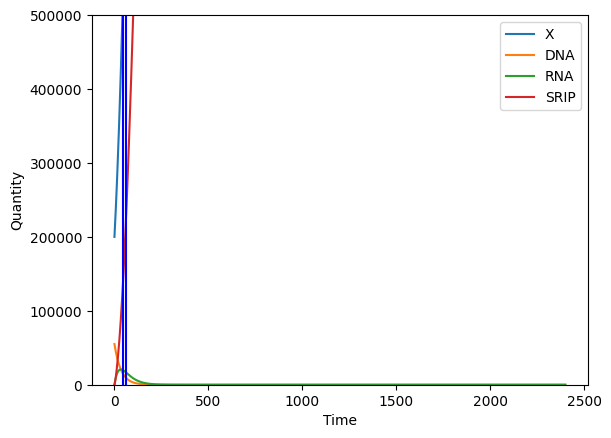

In [9]:
# 微分方程式系の定義
def model(t, y):
    X, DNA, RNA, SRIP = y
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    # dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X - k_a * SRIP * X
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]


# solve_ivpを使って数値解を求める
t_min, t_end = 0, 24 * 100
X0 = 0.2 * 1e6  # Xの初期値を適切に設定してください
DNA0 = 5.5 * 1e4  # Okumura
# DNA0 = 2.0 * 1e8
RNA0 = 0.0  # Okumura
SRIP0 = 0.0  # SRIPの初期値を適切に設定してください
y0 = [X0, DNA0, RNA0, SRIP0]
# y0 = [0.2 * 1e6, 2.0 * 1e11, 0.0, 0.0] # X0, DNA0, RNA0, SRIP0
sol = solve_ivp(model, [t_min, t_end], y0, t_eval=np.linspace(t_min, t_end, 1000))

# グラフ描画
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sol.t, sol.y[0], label='X')
ax.plot(sol.t, sol.y[1], label='DNA')
ax.plot(sol.t, sol.y[2], label='RNA')
ax.plot(sol.t, sol.y[3], label='SRIP')
ax.axvline(x=48, color='b')
ax.axvline(x=60, color='b')

ax.legend(loc='best')
ax.set_xlabel('Time')
ax.set_ylabel('Quantity')
ax.set_ylim(0, 5e5)
plt.show()

# fitting to experiment data

In [17]:
data = pd.read_csv('experiment.csv')
data = [[0] + data[str(i)].to_list()[:6] for i in range(1, 4)]
data = [[data[0][i], data[1][i], data[2][i]] for i in range(6)]
# data = [[data[0][i], data[2][i]] for i in range(6)]

In [18]:
data

[[0, 0, 0],
 [8639.484308, 3599.785128, 5039.69918],
 [244785.3887, 59036.4761, 282943.1111],
 [19438.83969, 5759.656205, 17998.92564],
 [2159.871077, 66236.04636, 719.9570257],
 [1439.914051, 0.0, 719.9570257]]

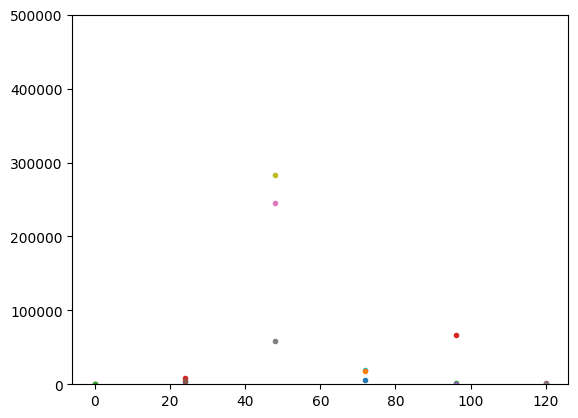

In [19]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

for i in range(6):
    datum = data[i]
    for j in range(len(data[i])):
        ax.plot(24 * i, datum[j], '.')
ax.set_ylim(0, 5e5)
plt.show()

In [214]:
# 実験データ
t_data = np.array([24*i for i in range(6)])  # 実験データの時間点
SRIP_data = np.array(data)  # 実験データのSRIPの値


# 微分方程式系の定義
def model(t, y, Ser, X_max):
    X, DNA, RNA, SRIP = y
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X - k_a * SRIP * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

# 誤差関数の定義
def objective(params):
    Ser, X_max = params
    sol = solve_ivp(model, [t_min, t_end], y0, args=(Ser, X_max), t_eval=t_data, method='RK45')
    
    model_output = sol.y[-1]
    experiment_data = np.mean(SRIP_data, axis=1)
    
    error = np.sum((model_output - experiment_data) ** 2)
    
    return error

# 最適化の実行
initial_params = [10, 1.0e6]
y0 = [0.2 * 1e6, 2.0 * 1e11, 0.0, 0]  # X, DNA, RNA, SRIP

result = minimize(objective, initial_params, bounds=[(0, 1e3), (0, 1.3 * 1e6)])
optimized_params = result.x

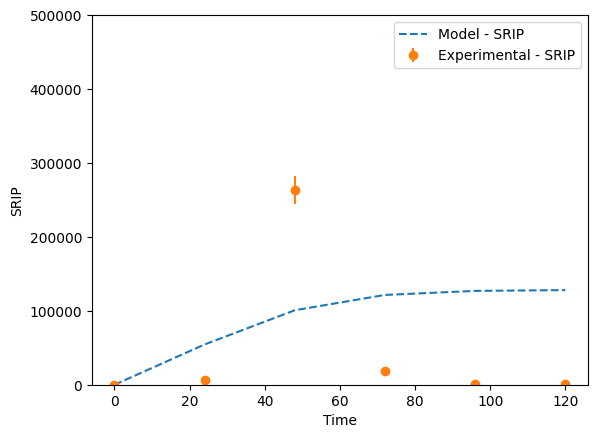

In [215]:
# solve_ivpで得られたシミュレーション結果をプロット
Ser, X_max = optimized_params

def model(t, y, Ser, X_max):
    X, DNA, RNA, SRIP = y
    dXdt = P * X * (X_max - X) / X_max * Ser / (Ser + K_ser)
    dDNAdt = -k_DNA * DNA
    dRNAdt = k_s * DNA - k_dRNA * RNA
    dSRIPdt = k_vp * RNA / (RNA + K_RNA) * X - k_a * SRIP * X
    
    return [dXdt, dDNAdt, dRNAdt, dSRIPdt]

y0 = [0.2 * 1e6, 2.0 * 1e11, 0.0, 0]  # X, DNA, RNA, SRIP
sol = solve_ivp(model, [t_min, t_end], y0, args=(Ser, X_max), t_eval=t_data, method='RK45')

# 実験データをプロット
# エラーバーを含める場合は、各サンプルの標準偏差や標準誤差を計算
mean_srip_data = np.mean(SRIP_data, axis=1)  # 各時間点での平均値
std_srip_data = np.std(SRIP_data, axis=1)  # 各時間点での標準偏差

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(sol.t, sol.y[-1], label='Model - SRIP', linestyle='dashed')
ax.errorbar(t_data, mean_srip_data, yerr=std_srip_data, fmt='o', label='Experimental - SRIP')

# グラフの設定
ax.set_xlabel('Time')
ax.set_ylabel('SRIP')
ax.legend(loc='best')
ax.set_ylim(0, 5e5)
plt.show()

In [216]:
optimized_params

array([1.00000000e+01, 1.00152409e+06])